In [25]:
import os
import torch
import pandas as pd
import numpy as np
import torchvision
import torch.nn as nn
from torch.utils.data import Dataset, random_split, DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
from collections import OrderedDict
%matplotlib inline

In [26]:
dataset = ImageFolder('/content/drive/MyDrive/roboi_breed_classification/data')

In [27]:
breeds=dataset.classes
num_cls=len(breeds)
breeds

['Chihuahua', 'Pomeranian', 'Welsh_corgi', 'etc', 'golden_retriever']

In [36]:
test_pct = 0.1
test_size = int(len(dataset)*test_pct)
dataset_size = len(dataset) - test_size

val_pct = 0.05

val_size = int(dataset_size*val_pct)
train_size = dataset_size - val_size


train_size, val_size, test_size

(6846, 360, 800)

In [37]:
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
len(train_ds), len(val_ds), len(test_ds)

(6846, 360, 800)

In [38]:
class DogBreedDataset(Dataset):
    
    def __init__(self, ds, transform=None):
        self.ds = ds
        self.transform = transform
        
    def __len__(self):
        return len(self.ds)
    
    def __getitem__(self, idx):
        img, label = self.ds[idx]
        if self.transform:
            img = self.transform(img)  
            return img, label

In [39]:
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

train_transform = transforms.Compose([
#    transforms.Resize((224, 224)),
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224, padding=4, padding_mode='reflect'),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomRotation(degrees=30),
    transforms.ToTensor(),
#    transforms.Normalize(*imagenet_stats, inplace=True)
    
])


val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
#    transforms.Normalize(*imagenet_stats, inplace=True)
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)), 
    transforms.ToTensor(),
#    transforms.Normalize(*imagenet_stats, inplace=True)
])

In [40]:
train_dataset = DogBreedDataset(train_ds, train_transform)
val_dataset = DogBreedDataset(val_ds, val_transform)
test_dataset = DogBreedDataset(test_ds, test_transform)

2


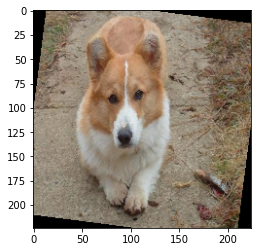

In [41]:
img, label = train_dataset[6]
print(label)
plt.imshow(img.permute(1,2,0))

In [42]:
batch_size =64

# Create DataLoaders
train_dl = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_dataset, batch_size*2, num_workers=2, pin_memory=True)
test_dl = DataLoader(test_dataset, batch_size*2, num_workers=2, pin_memory=True)

In [13]:
def show_batch(dl):
    for img, lb in dl:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(img.cpu(), nrow=16).permute(1,2,0))
        break

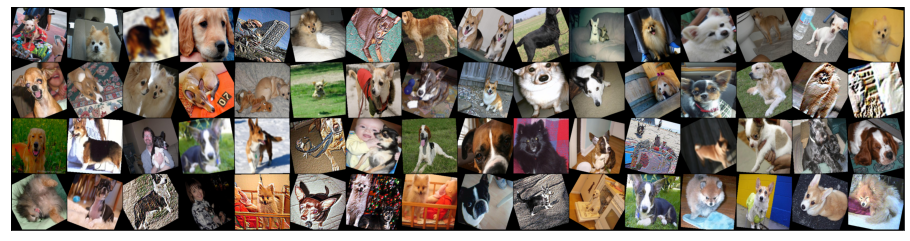

In [14]:
show_batch(train_dl)

In [43]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [44]:
class ImageClassificationBase(nn.Module):
    # training step
    def training_step(self, batch):
        img, targets = batch
        out = self(img)
        loss = F.nll_loss(out, targets)
        return loss
    
    # validation step
    def validation_step(self, batch):
        img, targets = batch
        out = self(img)
        loss = F.nll_loss(out, targets)
        acc = accuracy(out, targets)
        return {'val_acc':acc.detach(), 'val_loss':loss.detach()}
    
    # validation epoch end
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss':epoch_loss.item(), 'val_acc':epoch_acc.item()}
        
    # print result end epoch
    def epoch_end(self, epoch, result):
        print("Epoch [{}] : train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result["train_loss"], result["val_loss"], result["val_acc"]))
        

In [45]:
class DogBreedPretrainedResnet34(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        
        self.network = models.resnet34(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Sequential(
            nn.Linear(num_ftrs, num_cls),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, xb):
        return self.network(xb)

In [46]:
# model = DogBreedClassificationCNN()
model = DogBreedPretrainedResnet34()
# model

In [47]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(d, device) for d in data]
    else:
        return data.to(device, non_blocking=True)

In [48]:
class DeviceDataLoader:
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __len__(self):
        return len(self.dl)
    
    def __iter__(self):
        for batch in self.dl:
            yield to_device(batch, self.device)

In [49]:
# getting default device
device = get_default_device()
print(device)

# moving train dataloader and val dataloader to gpu
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)


# moving model to gpu
to_device(model, device);

cuda


In [50]:
# check the model 
def try_batch(dl):
    for imgs, labels in dl:
        print("images shape : ", imgs.shape)
        print("labels : ", labels)
        outs = model(imgs)                                  # Change model object here
        print("outs.shape :", outs.shape)
        print("outs : ", outs)
        break
        
try_batch(train_dl)

images shape :  torch.Size([64, 3, 224, 224])
labels :  tensor([3, 3, 2, 1, 1, 4, 2, 1, 1, 1, 2, 1, 4, 2, 4, 0, 1, 3, 3, 3, 3, 1, 0, 3,
        0, 1, 1, 1, 0, 1, 3, 2, 1, 1, 3, 4, 4, 3, 4, 2, 3, 2, 3, 3, 3, 4, 2, 3,
        4, 0, 3, 0, 0, 1, 4, 3, 4, 3, 0, 2, 3, 2, 3, 2], device='cuda:0')
outs.shape : torch.Size([64, 5])
outs :  tensor([[-1.8061, -1.8902, -0.9075, -2.1307, -1.8178],
        [-2.1626, -1.5019, -1.8243, -2.4158, -0.8876],
        [-1.4421, -1.6995, -1.0349, -2.4655, -1.9623],
        [-1.7695, -2.3780, -1.5831, -2.0171, -0.9202],
        [-2.1748, -1.6651, -1.5186, -1.9716, -1.0819],
        [-2.4851, -1.7461, -1.2952, -1.5497, -1.3623],
        [-1.4578, -2.0265, -1.3006, -1.9707, -1.4973],
        [-2.5393, -1.1701, -2.1449, -1.6888, -1.1747],
        [-1.7541, -1.4268, -2.0459, -1.5175, -1.4340],
        [-2.2256, -1.5456, -1.9004, -1.7963, -1.0123],
        [-1.4856, -1.9441, -1.6522, -2.3724, -1.0624],
        [-1.5827, -1.9001, -2.0995, -1.8220, -1.0194],
        [

In [51]:
from tqdm.notebook import tqdm

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
        

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0, grad_clip=None, opt_func = torch.optim.Adam):
    torch.cuda.empty_cache()
    history = []
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # set up one cycle lr scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        
        # Training phase
        model.train()       
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            
            # calculates gradients
            loss.backward()
            
            # check gradient clipping 
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                
            # perform gradient descent and modifies the weights
            optimizer.step()
            
            # reset the gradients
            optimizer.zero_grad()
            
            # record and update lr
            lrs.append(get_lr(optimizer))
            
            # modifies the lr value
            sched.step()
            
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
        
        
    return history
        
    

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [52]:
evaluate(model, val_dl)                 # change model object here

{'val_acc': 0.16185897588729858, 'val_loss': 1.8279980421066284}

In [54]:
# set hyperparams
num_epochs = 15
max_lr = 0.01
opt_func = torch.optim.SGD
grad_clip = 0.1
weight_decay = 1e-4

In [55]:
history = fit_one_cycle(num_epochs, max_lr, model, train_dl, val_dl, weight_decay, grad_clip, opt_func) 


Epoch [0] : train_loss: 0.6730, val_loss: 0.2136, val_acc: 0.9191



Epoch [1] : train_loss: 0.1731, val_loss: 0.2206, val_acc: 0.9145



Epoch [2] : train_loss: 0.1415, val_loss: 0.4407, val_acc: 0.8608



Epoch [3] : train_loss: 0.1106, val_loss: 0.2305, val_acc: 0.9307



Epoch [4] : train_loss: 0.0944, val_loss: 0.2053, val_acc: 0.9331



Epoch [5] : train_loss: 0.0740, val_loss: 0.1837, val_acc: 0.9313



Epoch [6] : train_loss: 0.0579, val_loss: 0.1213, val_acc: 0.9643



Epoch [7] : train_loss: 0.0308, val_loss: 0.1332, val_acc: 0.9565



Epoch [8] : train_loss: 0.0251, val_loss: 0.1305, val_acc: 0.9675



Epoch [9] : train_loss: 0.0261, val_loss: 0.1594, val_acc: 0.9649



Epoch [10] : train_loss: 0.0210, val_loss: 0.0611, val_acc: 0.9844



Epoch [11] : train_loss: 0.0131, val_loss: 0.0469, val_acc: 0.9844



Epoch [12] : train_loss: 0.0088, val_loss: 0.0416, val_acc: 0.9864



Epoch [13] : train_loss: 0.0046, val_loss: 0.0411, val_acc: 0.9864



Epoch [14] : train_loss: 0.0060, val_loss: 0.0482, val_acc: 0.9832


In [56]:
num_epochs = 5
max_lr = 0.001
history += fit_one_cycle(num_epochs, max_lr, model, train_dl, val_dl, weight_decay, grad_clip, opt_func)


Epoch [0] : train_loss: 0.0067, val_loss: 0.0396, val_acc: 0.9864



Epoch [1] : train_loss: 0.0032, val_loss: 0.0449, val_acc: 0.9832



Epoch [2] : train_loss: 0.0049, val_loss: 0.0383, val_acc: 0.9896



Epoch [3] : train_loss: 0.0050, val_loss: 0.0503, val_acc: 0.9832



Epoch [4] : train_loss: 0.0056, val_loss: 0.0450, val_acc: 0.9896


In [57]:
num_epochs = 3
max_lr = 0.0001
history += fit_one_cycle(num_epochs, max_lr, model, train_dl, val_dl, weight_decay, grad_clip, opt_func)


Epoch [0] : train_loss: 0.0055, val_loss: 0.0429, val_acc: 0.9896



Epoch [1] : train_loss: 0.0040, val_loss: 0.0403, val_acc: 0.9896



Epoch [2] : train_loss: 0.0062, val_loss: 0.0378, val_acc: 0.9896


In [56]:
history[0].keys()

dict_keys(['val_loss', 'val_acc', 'train_loss', 'lrs'])

In [58]:
val_loss = []
train_loss = []
val_acc = []
time = list(range(len(history)))
for h in history:
    val_loss.append(h['val_loss'])
    train_loss.append(h['train_loss'])
    val_acc.append(h['val_acc'])

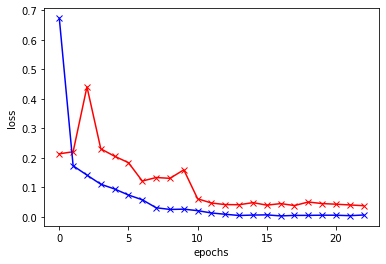

In [59]:
plt.plot(time, val_loss, c='red', label='val_loss', marker='x')
plt.plot(time, train_loss, c='blue', label='train_loss', marker='x')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

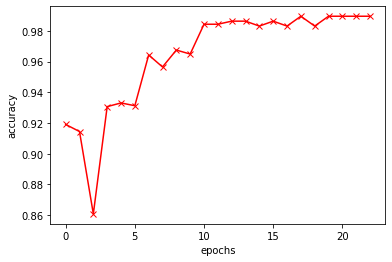

In [60]:
plt.plot(time, val_acc, c='red', label='accuracy', marker='x')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

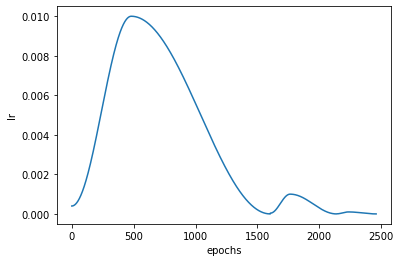

In [61]:
lrs = np.concatenate([x.get('lrs', []) for x in history])
plt.xlabel('epochs')
plt.ylabel('lr')
plt.plot(lrs)
plt.show()

In [63]:
def predict_single(img, label):
    print(img.shape, type(img))
    xb = img.unsqueeze(0) # adding extra dimension
    print(xb.shape, type(xb))
    xb = to_device(xb, device)
    preds = model(xb)                   # change model object here
    predictions = preds[0]
    
    max_val, kls = torch.max(predictions, dim=0)
    print('Actual :', breeds[label], ' | Predicted :', breeds[kls])
    plt.imshow(img.permute(1,2,0))
    plt.show()

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(d, device) for d in data]
    else:
        return data.to(device, non_blocking=True)

torch.Size([3, 224, 224]) <class 'torch.Tensor'>
torch.Size([1, 3, 224, 224]) <class 'torch.Tensor'>
Actual : etc  | Predicted : etc


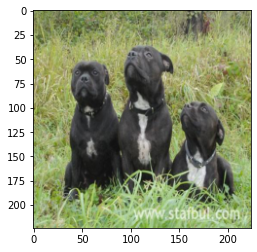

In [64]:
predict_single(*test_dataset[534])

In [62]:
# weights_fname = '/content/drive/MyDrive/dog-breed-classifier_0422_res34.pth'
# weights_fname = '/content/drive/MyDrive/roboi_breed_classification/breedClassifier_0620_res34.pt'
weights_fname = '/content/breedClassifier_06201254_res34.pt'
torch.save(model.state_dict(), weights_fname)

# Load Saved Weights to model

In [66]:
# weights_fname = '/content/drive/MyDrive/roboi_breed_classification/breedClassifier_0620_res34.pt'
weights_fname = '/content/breedClassifier_0620_res34.pt'
device = torch.device("cuda")
model.load_state_dict(torch.load(weights_fname))
model.to(device)

DogBreedPretrainedResnet34(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, aff

Actual : Chihuahua  | Predicted : Chihuahua


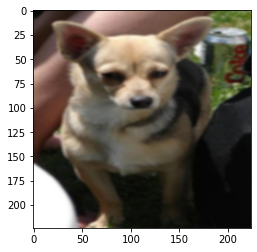

Actual : Chihuahua  | Predicted : Chihuahua


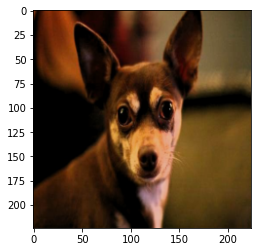

Actual : Chihuahua  | Predicted : Chihuahua


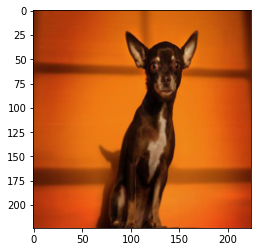

Actual : Chihuahua  | Predicted : Chihuahua


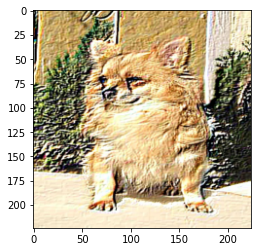

Actual : Chihuahua  | Predicted : Chihuahua


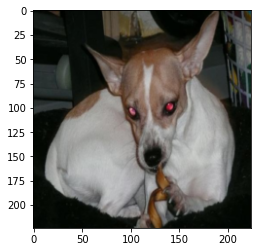

Actual : Chihuahua  | Predicted : Chihuahua


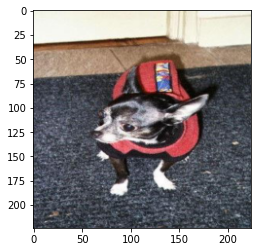

Actual : Chihuahua  | Predicted : Chihuahua


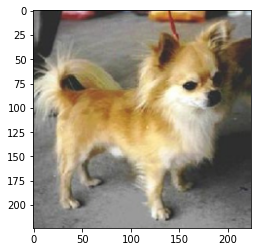

Actual : Chihuahua  | Predicted : Chihuahua


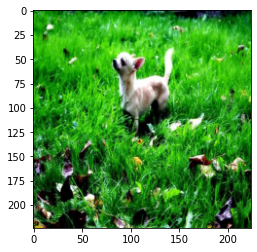

Actual : Chihuahua  | Predicted : Chihuahua


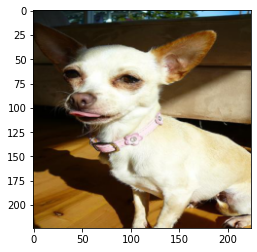

Actual : Chihuahua  | Predicted : Chihuahua


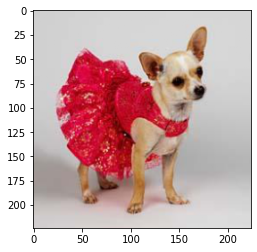

Actual : Chihuahua  | Predicted : Chihuahua


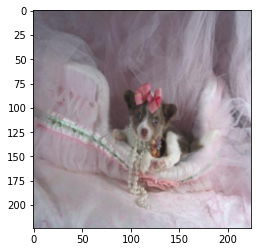

Actual : Chihuahua  | Predicted : Chihuahua


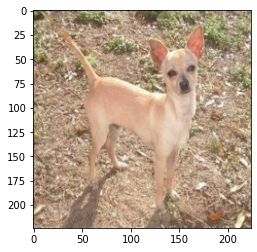

KeyboardInterrupt: ignored

In [67]:
def predict_single(img, label):
    xb = img.unsqueeze(0) # adding extra dimension
    xb = to_device(xb, device)
    preds = model(xb)                   # change model object here
    predictions = preds[0]
    
    max_val, kls = torch.max(predictions, dim=0)
    print('Actual :', breeds[label], ' | Predicted :', breeds[kls])
    plt.imshow(img.permute(1,2,0))
    plt.show()
# print(breeds)

for img,label in test_dataset:
    if label in [0,56,107,111,112]:
        predict_single(img, label)


In [68]:
for idx, breed in enumerate(breeds):
    # print(breed)
    if breed in ['golden retriever','Pembroke','Cardigan','Pomeranian','Chihuahua']:
        print(breed, idx)

Chihuahua 0
Pomeranian 1
